In [1]:
# GPU selection
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import time
import numpy as np
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import tensorflow as tf
import tensorflow.keras.layers as l
from nvstatsrecorder.recorders import NVStatsRecorder

In [3]:
print("TensorFlow version:", tf.__version__)
print("cuDNN version:", os.environ["CUDNN_VERSION"])
print("CUDA version:", os.environ["CUDA_VERSION"])

TensorFlow version: 2.1.0
cuDNN version: 7.6.5.32
CUDA version: 10.1.243


In [4]:
num_img = 16
num_filter = 128
num_it = 50000
num_it = 10 + num_it//num_img
dtype = tf.float16
kernel = (3,3)

In [5]:
with tf.device('/device:GPU:0'):
    synthetic_data = tf.random.normal((num_img,224,224,128),
                                      mean=0.0,
                                      stddev=0.5,
                                      dtype=dtype)
    
    depsep_conv_2d = l.SeparableConv2D(filters=num_filter, kernel_size=kernel, dtype=dtype)
    conv_2d = l.Conv2D(filters=num_filter, kernel_size=kernel, dtype=dtype)

    @tf.function
    def conv_2d_forward(data):
        return conv_2d(data)
    
    @tf.function
    def depsep_conv_2d_forward(data):
        return depsep_conv_2d(data)
        
    # warm-up
    print("Warm-up...")
    for _ in range(3):
        conv_2d_forward(synthetic_data)
        conv_2d_forward(synthetic_data).numpy()
        depsep_conv_2d_forward(synthetic_data)
        depsep_conv_2d_forward(synthetic_data).numpy()
    print("Warm-up completed")
    
    print("Remove constant overhead:")
    st = time.time()
    for _ in range(30):
        conv_2d_forward(synthetic_data).numpy()
    et = time.time()
    conv_overhead = (et-st)/30
    print("* Conv2D:", conv_overhead)
    st = time.time()
    for _ in range(30):
        depsep_conv_2d_forward(synthetic_data).numpy()
    et = time.time()
    depsep_conv_overhead = (et-st)/30
    print("* SeparableConv2D:", depsep_conv_overhead)

Warm-up...
Warm-up completed
Remove constant overhead:
* Conv2D: 0.16797937552134196
* SeparableConv2D: 0.16774467627207437


In [6]:
!gpustat

c8c49bb95805             Fri Jan 24 10:36:04 2020  430.50
[0] Tesla V100-DGXS-16GB | 41'C,   0 % |   304 / 16155 MB |
[1] Tesla V100-DGXS-16GB | 42'C,   0 % |     1 / 16158 MB |
[2] Tesla V100-DGXS-16GB | 44'C,   0 % |  1959 / 16158 MB |
[3] Tesla V100-DGXS-16GB | 42'C,   0 % |  2999 / 16158 MB |


In [7]:
print("Benchmark for Conv2D", kernel, dtype)

nv_stats_recorder = NVStatsRecorder(gpu_index=2)

nv_stats_recorder.start(interval=0.1)
st = time.time()
for _ in range(num_it-1):
    conv_2d_forward(synthetic_data)
conv_2d_forward(synthetic_data).numpy()
et = time.time()
nv_stats_recorder.stop()

stats = nv_stats_recorder.get_data()
mean_sm_util = round(np.mean(stats["sm_util_history"][10:-10]), 1)
mean_mem_util = round(np.mean(stats["mem_util_history"][10:-10]), 1)

print("Mean SM Util:", mean_sm_util)
print("Mean mem Util:", mean_mem_util)

tt = et - st - conv_overhead
conv_2d_score = int(num_img*num_it/tt)

print("Conv2D per sec:", conv_2d_score)

Benchmark for Conv2D (3, 3) <dtype: 'float16'>
Mean SM Util: 100.0
Mean mem Util: 35.0
Conv2D per sec: 4097


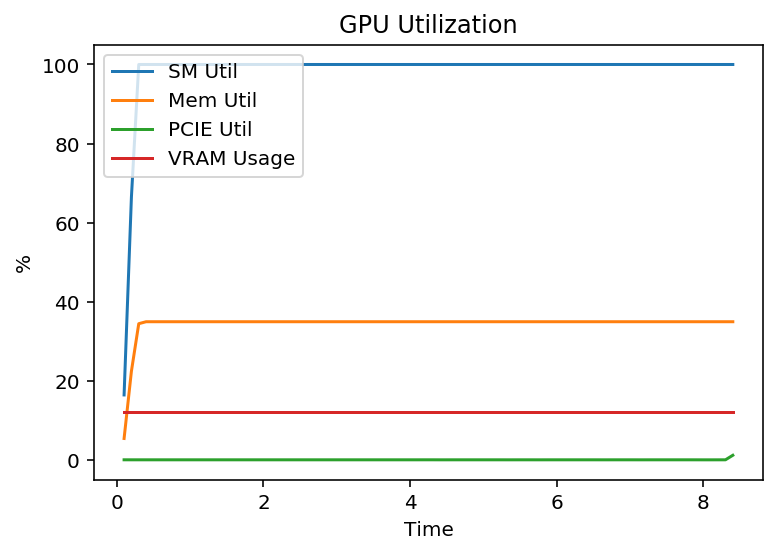

In [8]:
nv_stats_recorder.plot_gpu_util(smooth=2)

In [9]:
print("Benchmark for SeparableConv2D", kernel, dtype)

nv_stats_recorder = NVStatsRecorder(gpu_index=2)

nv_stats_recorder.start(interval=0.1)
st = time.time()
for _ in range(num_it-1):
    depsep_conv_2d_forward(synthetic_data)
depsep_conv_2d_forward(synthetic_data).numpy()
et = time.time()
nv_stats_recorder.stop()

stats = nv_stats_recorder.get_data()
mean_sm_util = round(np.mean(stats["sm_util_history"][10:-10]), 1)
mean_mem_util = round(np.mean(stats["mem_util_history"][10:-10]), 1)

print("Mean SM Util:", mean_sm_util)
print("Mean mem Util:", mean_mem_util)

tt = et - st - depsep_conv_overhead
depsep_conv_2d_score = int(num_img*num_it/tt)

print("SeparableConv2D per sec:", depsep_conv_2d_score)

Benchmark for SeparableConv2D (3, 3) <dtype: 'float16'>
Mean SM Util: 100.0
Mean mem Util: 54.0
SeparableConv2D per sec: 4335


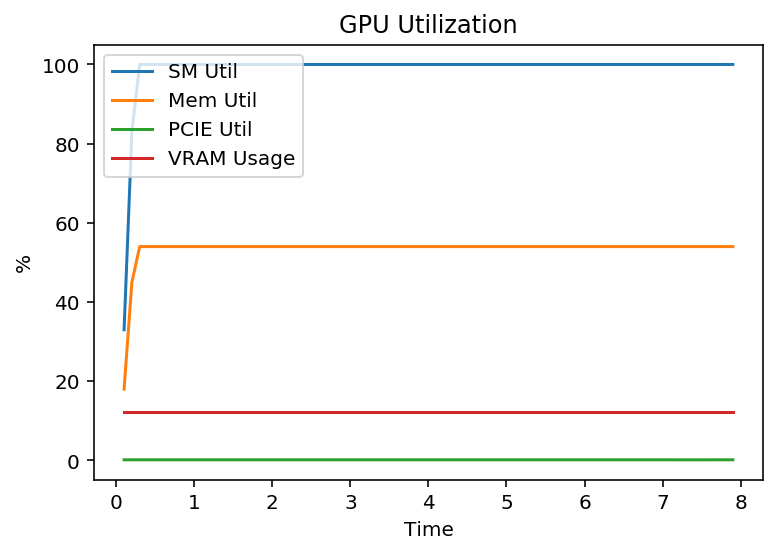

In [10]:
nv_stats_recorder.plot_gpu_util(smooth=2)